In [2]:
# !pip install segment-anything-py

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from segment_anything import sam_model_registry, SamPredictor
from transformers import pipeline
from PIL import Image

# --- CONFIGURAÇÃO ---
IMAGE_PATH = "imagem.jpg"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_h"
ALTURA_REAL_PESSOA = 5.9  # Metros

--- ETAPA DE SELEÇÃO ---


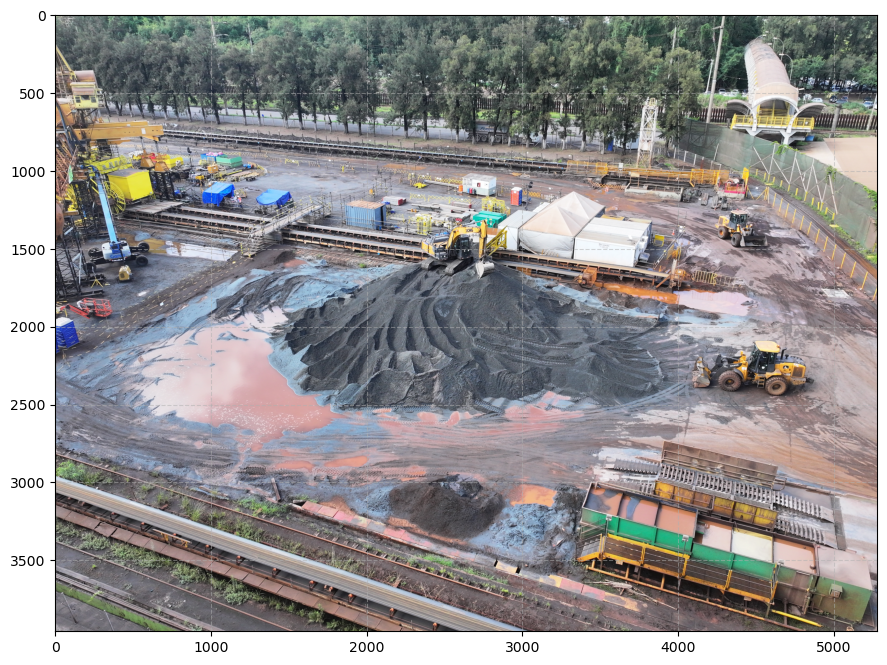


--- 1. SOBRE A PILHA ---


Digite X do centro da PILHA:  2650
Digite Y do centro da PILHA:  1700



--- 2. SOBRE A PESSOA (Referência) ---


Digite X do centro da PESSOA:  3650
Digite Y do centro da PESSOA:  1530



Carregando SAM (cpu)...
Carregando estimador de profundidade.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Segmentando a pessoa/referência.

--- CALIBRAÇÃO ---
Altura detectada (px): 325
Escala: 1 pixel = 0.01815 m
Área por pixel: 0.000330 m²
Segmentando a pilha...
Calculando volume estimado...

--- RESULTADOS FINAIS ---
Altura Máxima: 16.96 m
Perímetro Base: 122.38 m
Área Base: 545.41 m²
VOLUME ESTIMADO: 5050.82 m³


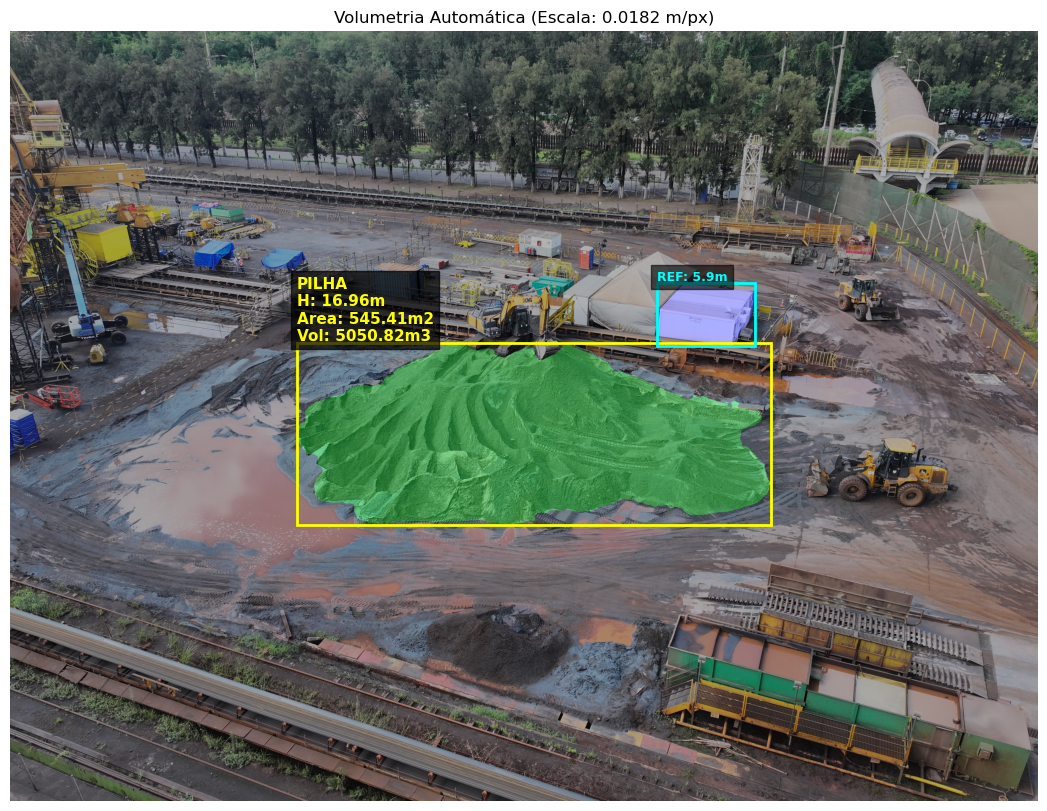

In [2]:
image_bgr = cv2.imread(IMAGE_PATH)
if image_bgr is None:
    raise FileNotFoundError(f"Imagem {IMAGE_PATH} não encontrada.")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print("--- ETAPA DE SELEÇÃO ---")
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

try:
    print("\n--- 1. SOBRE A PILHA ---")
    x_pile = int(input("Digite X do centro da PILHA: "))
    y_pile = int(input("Digite Y do centro da PILHA: "))
    
    print("\n--- 2. SOBRE A PESSOA (Referência) ---")
    x_person = int(input("Digite X do centro da PESSOA: "))
    y_person = int(input("Digite Y do centro da PESSOA: "))
except ValueError:
    print("Erro: Digite apenas números inteiros.")
    exit()

# --- 2. PREPARAÇÃO DOS MODELOS ---
print(f"\nCarregando SAM ({DEVICE})...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

# Carregando Depth Anything antes do volume
print("Carregando estimador de profundidade.")
depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf", device=-1)

# --- 3. SEGMENTAÇÃO DA PESSOA (CALIBRAÇÃO) ---
print("Segmentando a pessoa/referência.")
input_point_person = np.array([[x_person, y_person]])
input_label_person = np.array([1])

masks_p, scores_p, _ = predictor.predict(
    point_coords=input_point_person,
    point_labels=input_label_person,
    multimask_output=True,
)
mask_person = masks_p[np.argmax(scores_p)]

# Cálculo da Escala
contours_p, _ = cv2.findContours(mask_person.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_cnt_person = max(contours_p, key=cv2.contourArea)
_, _, _, h_p = cv2.boundingRect(largest_cnt_person)

pixel_height_person = h_p
ratio_px_to_meter = ALTURA_REAL_PESSOA / pixel_height_person
area_per_pixel_m2 = ratio_px_to_meter ** 2

print(f"\n--- CALIBRAÇÃO ---")
print(f"Altura detectada (px): {pixel_height_person}")
print(f"Escala: 1 pixel = {ratio_px_to_meter:.5f} m")
print(f"Área por pixel: {area_per_pixel_m2:.6f} m²")

# --- 4. SEGMENTAÇÃO DA PILHA ---
print("Segmentando a pilha...")
input_point_pile = np.array([[x_pile, y_pile]])
input_label_pile = np.array([1])

masks_pile, scores_pile, _ = predictor.predict(
    point_coords=input_point_pile,
    point_labels=input_label_pile,
    multimask_output=True,
)
mask_pile = masks_pile[np.argmax(scores_pile)]

# --- 5. GEOMETRIA DA PILHA (Área, Perímetro, Altura Visual) ---
contours_pile, _ = cv2.findContours(mask_pile.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_cnt_pile = max(contours_pile, key=cv2.contourArea)

# Perímetro
perimeter_px = cv2.arcLength(largest_cnt_pile, True)
perimeter_m = perimeter_px * ratio_px_to_meter

# Altura Visual Máxima (Bounding Box)
x_m, y_m, w_m, h_m = cv2.boundingRect(largest_cnt_pile)
height_pile_m = h_m * ratio_px_to_meter

# Área da Base
area_px = cv2.contourArea(largest_cnt_pile)
area_m2 = area_px * area_per_pixel_m2

# --- 6. CÁLCULO DE VOLUME (INTEGRAÇÃO COM DEPTH MAP) ---
print("Calculando volume estimado...")

# Gerar Depth Map
pil_image = Image.fromarray(image_rgb)
depth_output = depth_estimator(pil_image)
raw_depth_map = np.array(depth_output["depth"])

if raw_depth_map.shape != image_rgb.shape[:2]:
    raw_depth_map = cv2.resize(raw_depth_map, (image_rgb.shape[1], image_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)

# A. Isolar profundidade da pilha
pile_depth_values = raw_depth_map[mask_pile]

d_min = pile_depth_values.min()
d_max = pile_depth_values.max()

if d_max > d_min:
    # Normaliza entre 0 e 1
    depth_normalized = (pile_depth_values - d_min) / (d_max - d_min)
else:
    depth_normalized = np.zeros_like(pile_depth_values)

# C. Calcular Volume
# Volume = Soma (Área do Pixel * Altura Estimada daquele Pixel)
pixel_heights_m = depth_normalized * height_pile_m
volume_m3 = np.sum(pixel_heights_m * area_per_pixel_m2)

print(f"\n--- RESULTADOS FINAIS ---")
print(f"Altura Máxima: {height_pile_m:.2f} m")
print(f"Perímetro Base: {perimeter_m:.2f} m")
print(f"Área Base: {area_m2:.2f} m²")
print(f"VOLUME ESTIMADO: {volume_m3:.2f} m³")

# --- 7. VISUALIZAÇÃO ---
plt.figure(figsize=(14, 10))
plt.imshow(image_rgb)

# Máscaras
overlay = np.zeros_like(image_rgb)
overlay[mask_pile] = [0, 255, 0]
overlay[mask_person] = [0, 0, 255]
plt.imshow(overlay, alpha=0.3)

# Info Pilha
rect_pile = plt.Rectangle((x_m, y_m), w_m, h_m, linewidth=2, edgecolor='yellow', facecolor='none')
plt.gca().add_patch(rect_pile)

# Formatando texto com Volume
info_text = (
    f"PILHA\n"
    f"H: {height_pile_m:.2f}m\n"
    f"Area: {area_m2:.2f}m2\n"
    f"Vol: {volume_m3:.2f}m3"
)
plt.text(x_m, y_m - 10, info_text, color='yellow', fontsize=11, fontweight='bold', bbox=dict(facecolor='black', alpha=0.7))

# Info Pessoa
x_p, y_p, w_p, h_p = cv2.boundingRect(mask_person.astype(np.uint8))
rect_person = plt.Rectangle((x_p, y_p), w_p, h_p, linewidth=2, edgecolor='cyan', facecolor='none')
plt.gca().add_patch(rect_person)
plt.text(x_p, y_p - 10, f"REF: {ALTURA_REAL_PESSOA}m", color='cyan', fontsize=9, fontweight='bold', bbox=dict(facecolor='black', alpha=0.6))

plt.title(f"Volumetria Automática (Escala: {ratio_px_to_meter:.4f} m/px)")
plt.axis('off')
plt.show()
